In [26]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import random
import argparse
import os
import json

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

# Load data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


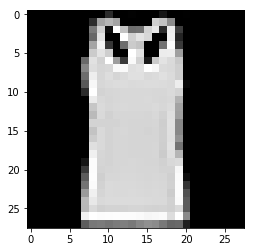

In [4]:
plt.imshow(x_train[random.randint(0, x_train.shape[0])], cmap='gray')

In [5]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Define params and helper

In [6]:
img_size_ori = x_train.shape[1]
x_train = np.reshape(x_train, [-1, img_size_ori])
x_test = np.reshape(x_test, [-1, img_size_ori])
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Define Model

In [7]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

## Encoder part

In [8]:
input_shape = (img_size_ori, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

In [15]:

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(img_size_ori, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
    
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [20]:
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28)                0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 16900     
_________________________________________________________________
decoder (Model)              (None, 28)                15900     
Total params: 32,800
Trainable params: 32,800
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Define Loss

In [22]:
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= img_size_ori

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [23]:
vae.compile(optimizer='adam')

In [24]:
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 1680000 samples, validate on 280000 samples
Epoch 1/50
1680000/1680000 [==============================] - 25s 15us/step - loss: 0.0287 - val_loss: 8.7956e-05
Epoch 2/50
1680000/1680000 [==============================] - 23s 14us/step - loss: 8.4703e-05 - val_loss: 8.4086e-05
Epoch 3/50
1680000/1680000 [==============================] - 23s 14us/step - loss: 8.4501e-05 - val_loss: 8.4109e-05
Epoch 4/50
1680000/1680000 [==============================] - 25s 15us/step - loss: 8.4502e-05 - val_loss: 8.4238e-05
Epoch 5/50
1680000/1680000 [==============================] - 24s 14us/step - loss: 8.4479e-05 - val_loss: 8.4130e-05
Epoch 6/50
1680000/1680000 [==============================] - 24s 14us/step - loss: 8.4459e-05 - val_loss: 8.4334e-05
Epoch 7/50
1680000/1680000 [==============================] - 27s 16us/step - loss: 8.4442e-05 - val_loss: 8.4261e-05
Epoch 8/50
1680000/1680000 [==============================] - 25s 15us/step - loss: 8.4416e-05 - val_loss: 8.3995e-05
Epoch 9

In [25]:
vae.save_weights('../model/vae_mlp_fsmnist.h5')